In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("harvest_data_plus_environmental_data.csv")

In [3]:
data = data[data['SEX'] == 'F'] # subsetting data to just females

## EDA:

Text(0.5, 1.0, 'Average Age of Harvested Female Deer by Training Site')

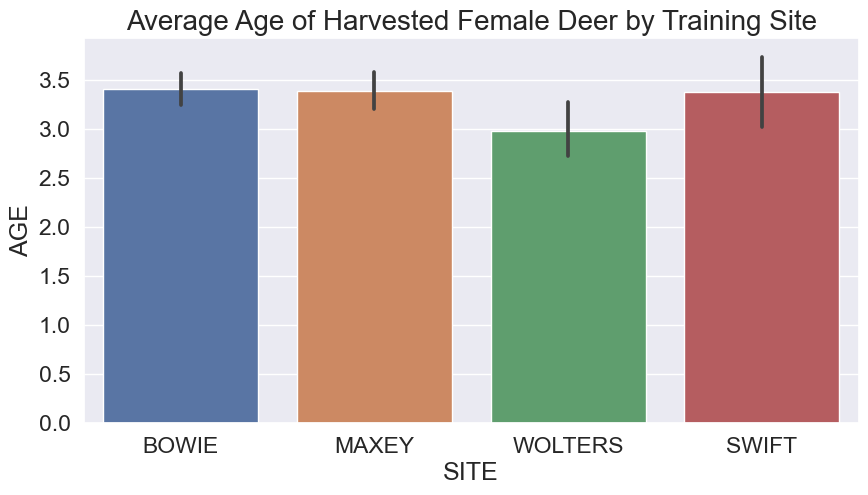

In [4]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average Age of Harvested Female Deer by Training Site', fontsize=20)

Text(0.5, 1.0, 'Number of Females Harvested by Year')

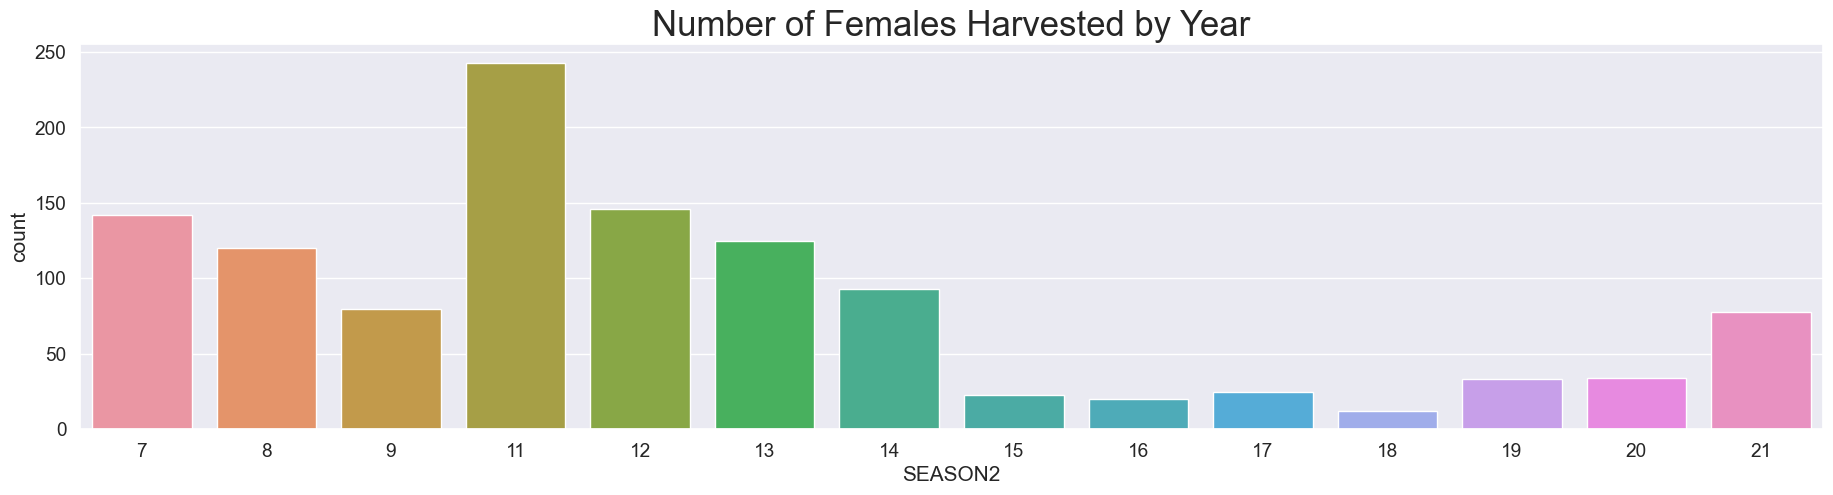

In [5]:
sns.set(rc={"figure.figsize":(22.5, 5)}, font_scale = 1.25) 
sns.countplot(x = 'SEASON2', data = data)
plt.title('Number of Females Harvested by Year', fontsize=25) 

# the x-axis values correspond to year (e.g., '7' = 2007, '10' = 2010, and so on.)

Text(0.5, 1.0, 'Female Body Mass (bm.kg) by Age')

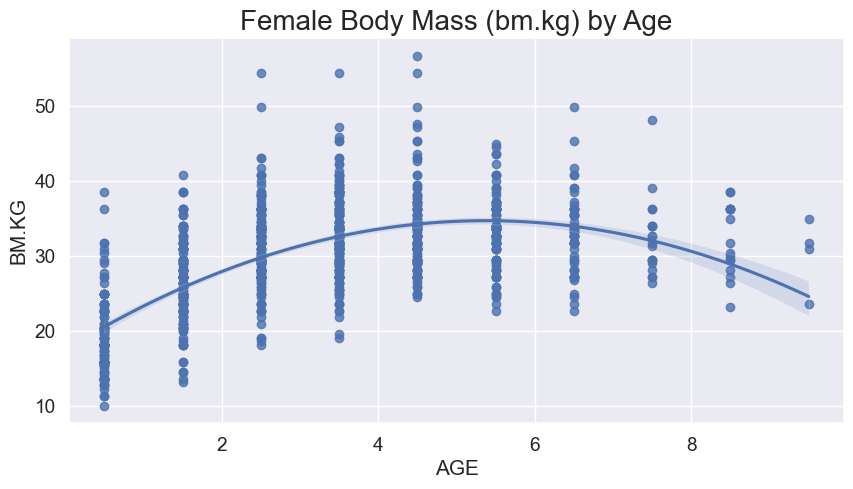

In [6]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'AGE', y = 'BM.KG', data = data, order=2)
plt.title('Female Body Mass (bm.kg) by Age', fontsize=20)

Notice the positive, curvilinear relationship between body mass and age.  However, as females reach about 6 years body mass pleateaus and begins to decline 

In [7]:
data.drop(['PREFIX-ID','DATE','ID','DATE+#','a,b,etc.','DATE TAKEN','SEASON','SEASONCAT','LIVE.BM.KG',
           'LIVE WEIGHT','BM.LB','POINTS.L','POINTS.R','SPREAD.IN','SPREAD.MM','BASAL.CIR.L.IN',
           'BASAL.CIR.L.MM','BASAL.CIR.R.IN','BASAL.CIR.R.MM ','BEAM.L.IN','BASAL.T.MM','BEAM.L.MM',
           'BEAM.R.IN','BEAM.R.MM','LACTATION','NOTES','BEAM.T.MM'],axis=1, inplace=True)

In [8]:
data['SITE'].replace(['BOWIE', 'SWIFT','MAXEY','WOLTERS'],[0, 1, 2, 3], inplace=True)
data['SEX'].replace(['M','F'],[0, 1], inplace=True)

In [9]:
data.dropna(subset=['BM.KG','AGE'],inplace=True)

In [10]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
SEASON2 : 0 NaN
SEX : 0 NaN
SITE : 0 NaN
AGE : 0 NaN
BM.KG : 0 NaN
rain_lag_0 : 0 NaN
rain_lag_1 : 0 NaN
rain_lag_2 : 0 NaN
rain_lag_3 : 0 NaN
rain_lag_4 : 0 NaN
rain_lag_5 : 0 NaN


Text(0.5, 1.0, 'Average Age of Harvested Female Deer by Training Site')

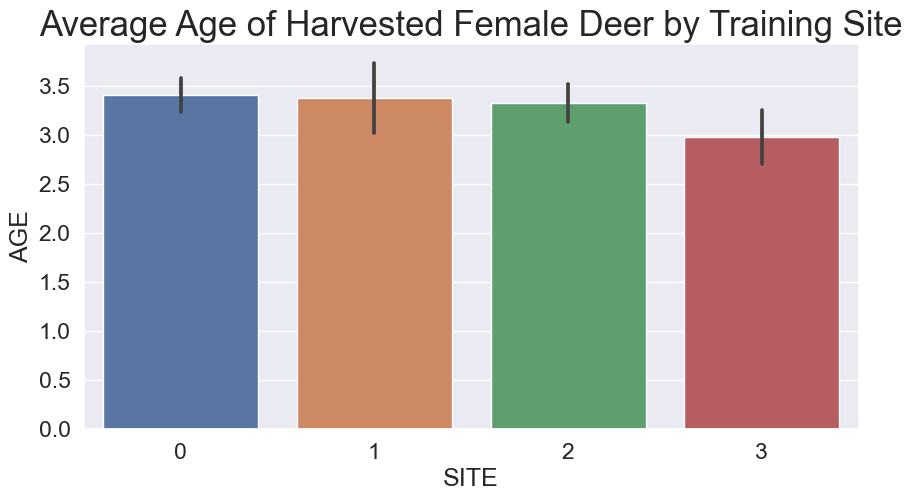

In [11]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average Age of Harvested Female Deer by Training Site', fontsize=25)

In [12]:
data.corr() # Looking at correlations between rain_lags.  Dropping all rain lags  that correlate highly with other rain lags

,SEASON2,SEX,SITE,AGE,BM.KG,rain_lag_0,rain_lag_1,rain_lag_2,rain_lag_3,rain_lag_4,rain_lag_5
SEASON2,1.000000,NaN,0.153382,-0.052264,0.182588,-0.066785,-0.096489,-0.041559,0.037364,0.014165,0.003704
SEX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SITE,0.153382,NaN,1.000000,-0.069704,0.054128,0.383484,0.384304,0.404867,0.327653,0.275382,0.380577
AGE,-0.052264,NaN,-0.069704,1.000000,0.523212,-0.014716,0.029003,0.021132,0.000590,0.021691,-0.027643
BM.KG,0.182588,NaN,0.054128,0.523212,1.000000,0.035494,0.004039,0.063696,0.130420,0.146541,-0.019874
rain_lag_0,-0.066785,NaN,0.383484,-0.014716,0.035494,1.000000,0.861820,0.911855,0.813127,0.665527,0.719990
rain_lag_1,-0.096489,NaN,0.384304,0.029003,0.004039,0.861820,1.000000,0.840518,0.653053,0.655613,0.786075
rain_lag_2,-0.041559,NaN,0.404867,0.021132,0.063696,0.911855,0.840518,1.000000,0.742564,0.606939,0.713324
rain_lag_3,0.037364,NaN,0.327653,0.000590,0.130420,0.813127,0.653053,0.742564,1.000000,0.723381,0.372963
rain_lag_4,0.014165,NaN,0.275382,0.021691,0.146541,0.665527,0.655613,0.606939,0.723381,1.000000,0.343644


Kept rain lag 3 and 4 because they are the only rain lags that don't correlate highly with other rain lags

In [13]:
X = data[['AGE','SITE','SEASON2', 'rain_lag_4', 'rain_lag_3']] 
y = data['BM.KG']

Fit a linear regression model initially 

In [14]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary()) ## not a bad r-squared.  

                            OLS Regression Results                            
Dep. Variable:                  BM.KG   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     105.8
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           2.37e-90
Time:                        14:37:28   Log-Likelihood:                -3309.1
No. Observations:                1046   AIC:                             6630.
Df Residuals:                    1040   BIC:                             6660.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2299      0.832     19.500      0.0

In [15]:
pred = est2.predict(X2)
print(pred)

0       31.520096
1       25.810938
2       27.713991
3       33.423148
4       35.326201
          ...    
1574    33.136184
1575    35.039237
1576    35.039237
1578    29.330079
1579    33.136184
Length: 1046, dtype: float64


In [16]:
mae = mean_absolute_error(data['BM.KG'], pred)
print("mean absolute error for the MLR {}".format(mae))

mean absolute error for the MLR 4.433051379479645


Contrast results of linear model with a few machine learning models to see if predictors' feature importances vary among fitted and tuned models

In [17]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

KFold cross validation to assess overfit

In [18]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [4.54500837 4.48750572 3.43106699 3.72193002 4.23278261 5.26211917
 3.31492536 3.70626455 4.10274151 4.30624791]
MAE average:  4.111059220735213


In [19]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [4.17487698 4.57048139 3.2890832  3.20008752 3.65679929 4.89385896
 3.2624375  3.59226108 3.95860428 4.20252586]
MAE average:  3.8801016069182808


In [20]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

MAE values:  [4.60206876 4.77378786 3.50084137 3.85004971 4.20163297 5.45735642
 3.48011176 3.48726182 4.57079267 5.01874719]
MAE average:  4.2942650537755505


Tune hyperparamters via grid search 

In [21]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [22]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [23]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [24]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [25]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [26]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
gs_xgbr.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


Assess if predictors have similar feature importance scores among models

In [ ]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.show()

In [ ]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.show()

In [ ]:
feat_importances = pd.Series(gs_xgbr.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(6.25, 3))
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.show()

Mostly agreement among the three models and linear model.  The linear model weighted 'SITE' (i.e., the training site where the deer was harvested) higher than the ML models 